# Introduction

For today's lab we will build a basic Bayesian regression using PyMC. We're going to use a data-set procured from a credit card company with basic demographic data, and a limit balance. The later will be the target for our regression, and we will use the categorical column: sex, education, marriage, and the numerical column age, as our features. 

The point of the lab will be to have greater familiarity with the PyMC environment as well as see how constructing a Bayesian regression is different from a classical multiple variable regression model. You'll note while doing the lab that building a Bayesian regression is often more involved, however, you'll also note that Bayesian regressions will give you, the data scientist more control over assumptions in the analytic model itself. 

With this added complexity, comes a cost in terms of actually executing/estimating the parameters of your model, and thus you'll have to leverage a powerful procedure (Monte-Carlo Markov Chains) to actually compute the regression. You should be excited, as with a little more work, and learning in this sub-area of data science can quickly lead to topics currently within the frontier such as deep learning. 

Let's begin!


# Load the Data

We'll be working with our second UCI Machine Learning Repository data set. 

The description of the data is as follows from the website (https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients#):

    This research aimed at the case of customersâ€™ default payments in Taiwan and compares the predictive accuracy of probability of default among six data mining methods. From the perspective of risk management, the result of predictive accuracy of the estimated probability of default will be more valuable than the binary result of classification - credible or not credible clients. Because the real probability of default is unknown, this study presented the novel â€œSorting Smoothing Methodâ€ to estimate the real probability of default. With the real probability of default as the response variable (Y), and the predictive probability of default as the independent variable (X), the simple linear regression result (Y = A + BX) shows that the forecasting model produced by artificial neural network has the highest coefficient of determination; its regression intercept (A) is close to zero, and regression coefficient (B) to one. Therefore, among the six data mining techniques, artificial neural network is the only one that can accurately estimate the real probability of default.
    
In this lab we're going to see what relationship simple demographics like sex, education, marriage status, and sex identifier have to the limit balance columns, but we'll build the regression model via the Bayesian paradigm and with PyMC, so you'll get more practice with this library and the associated methodologies. 

Load up the default data , we will be doing a MLR on the Balance with simple demographics, sex, education, marriage, and age as features

In [1]:
from __future__ import division
import os
import math
import pylab as py
import sys
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline


default = pd.read_csv('../assets/datasets/defaultcc.csv')
print(type(default))
default.head(10)


<class 'pandas.core.frame.DataFrame'>


,Unnamed: 0,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X15,X16,X17,X18,X19,X20,X21,X22,X23,Y
0,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
1,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
2,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
3,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
4,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
5,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0
6,6,50000,1,1,2,37,0,0,0,0,...,19394,19619,20024,2500,1815,657,1000,1000,800,0
7,7,500000,1,1,2,29,0,0,0,0,...,542653,483003,473944,55000,40000,38000,20239,13750,13770,0
8,8,100000,2,2,2,23,0,-1,-1,0,...,221,-159,567,380,601,0,581,1687,1542,0
9,9,140000,2,3,1,28,0,0,2,0,...,12211,11793,3719,3329,0,432,1000,1000,1000,0


# Define the features of our simple model

Utilize a simple list/array from Python's base language to house the column names for your features, label the list rhs (for "right-hand side"). 

Do the same for your target, and define the list "target". 

In [2]:
rhs = ['SEX', 'EDUCATION', 'MARRIAGE', 'AGE']
target = ['LIMIT_BAL']


# Assigning the distributions for our error term and constant

Define your intercept and error term. Label the error term "noise" and the intercept term "beta0". Please read the docs to understand how to call both the normal and uniform distirbution:  https://pymc-devs.github.io/pymc/

In [3]:
import pymc as pm
import numpy as np

beta0 = pm.Normal("beta0", 0, 0.0001)
noise = pm.Uniform("noise", 0, 500)

# Assigning the distribution for our parameters

Define two arrays b, and x, as an empty numpy array of size 4. 'b' will contain our parameter values, and x will contain our numerical data inputs for the right-hand side. 

In [4]:
b = np.empty(5, dtype=object)
x = np.empty(5, dtype=object)

You have 4 features on your right hand side, so you must define each feature (and its distribution). For simplicity-sake, just define each feature as normal distribution. We're more concerned with you building the model through the first time. 

Quick Challenge Question: What is the only feature in our right-hand side that could appropriately be modeled by a normal distribution? What would be a better distribution for the others (Hint: We've mentioned it previously). 

You might be asking, why do we want to do this? Well a couple reasons, but one of the more important rationales is because of automation. It would be much easier to call a set of parameters if they were housed in an array/vector via a loop as this is simply just array[index_number], whereas if we just housed each parameter in their own variable, we'd have to explicitly call the variable name to get that particular value from memory. 

**Note**: As with the previous labs, just define all normal distributions with a mean 0 and a standard deviation of .0001.


In [5]:
b1 = pm.Normal("b1", 0, 0.0001); b[1] = b1
b2 = pm.Normal("b2", 0, 0.0001); b[2] = b2
b3 = pm.Normal("b3", 0, 0.0001); b[3] = b3
b4 = pm.Normal("b4", 0, 0.0001); b[4] = b4


# Constructing the Functional Form of our Model

We've defined our parameters, we must now define our data. Again, for the sake of executing everything on the first run, let's assume the data is normally distributed (like the parameters) above, and put these data variables (there should be 4, one for each parameter variable) in the empty numpy array. |

In [6]:
col = default.iloc[0,:]
default.columns = col
default = default.drop(0)

In [7]:
default

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
1,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
2,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
3,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
4,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
5,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0
6,6,50000,1,1,2,37,0,0,0,0,...,19394,19619,20024,2500,1815,657,1000,1000,800,0
7,7,500000,1,1,2,29,0,0,0,0,...,542653,483003,473944,55000,40000,38000,20239,13750,13770,0
8,8,100000,2,2,2,23,0,-1,-1,0,...,221,-159,567,380,601,0,581,1687,1542,0
9,9,140000,2,3,1,28,0,0,2,0,...,12211,11793,3719,3329,0,432,1000,1000,1000,0
10,10,20000,1,3,2,35,-2,-2,-2,-2,...,0,13007,13912,0,0,0,13007,1122,0,0


In [8]:
x1 = pm.Normal("x1", 0, 1, default['SEX'] , observed = True); x[1] = x1
x2 = pm.Normal("x2", 0, 1, default['EDUCATION'] , observed = True); x[2] = x2
x3 = pm.Normal("x3", 0, 1, default['MARRIAGE'] , observed = True); x[3] = x3
x4 = pm.Normal("x4", 0, 1, default['AGE'] , observed = True); x[4] = x4


We previouslly said we'd come back to the two main model type classes, **deterministic** and **stochastic**. We're going to talk more about that now. Here is a reference 

https://pymc-devs.github.io/pymc/modelbuilding.html

The docs explain it best: 
    
    A Stochastic object represents a variable whose value is not completely determined by its parents, and a Deterministic object represents a variable that is entirely determined by its parents. In object-oriented programming parlance, Stochastic and Deterministic are subclasses of the Variable class, which only serves as a template for other classes and is never actually implemented in models.
    
So in plain english a deterministic model is one where all it's dependencies 'completely' define it. Think about a regression equation, what does it consist of? Parameters and data for features, a target, a constant term, and an error term. Have we accounted for all these components above in our specification? (Hint: Yes). So stands to reason we can use the deterministic class specifier.

Define a function, pred to be the assembled Bayesian regression

In [9]:
@pm.deterministic
def pred(beta0 = beta0, b = b, x = x):
    return beta0 + b[1]*x[1] + b[2]*x[2] + b[3]*x[3] + b[4]*x[4]


/Users/allenbyron/anaconda/lib/python2.7/site-packages/pymc/Node.py:403: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  self.__name__ = input['__name__']


We're almost done! The last ingredient to our model is the target. Like the features, we must define the distribution for this object. Again, assume normality, and label the target 'y'. 

In [10]:
y = pm.Normal("y", pred, noise, value = np.array(default[target]), observed = True)

model = pm.Model([beta0, pm.Container(b), noise, pm.Container(x), y, pred])

#  Construct a Graphical Representation of Our Bayesian Model

So part of the value of building a Bayesian model is we're able to represent the model as a directed graph (See: http://algs4.cs.princeton.edu/42digraph/). Although for these simpler examples the importance of this feature may be less evident, as you mature in data science you may eventually build more complicated Bayesian models, including Bayesian networks, where this representation of a model is more central to understanding the behavior of the algorithm.  

We're going to practice building such a graph on our simple Bayesian example. Construct a graphical representation of your Bayesian model - Hint you will need to have PyDot installed with GraphicViz


First import pydot and pymc's graph method. You'll also need to import display_png from Ipython's display method. Please read the following docs and familiarize yourself with GraphicViz with the following blog post: https://pythonhaven.wordpress.com/2009/12/09/generating_graphs_with_pydot/, you should also look at the docs and the library Git: https://pypi.python.org/pypi/pydot

In [11]:
import pydot
import pymc.graph
from IPython.display import display_png

Now call build a graphical representation of your model using pymc graph. Also, you now know where your "labels" show up when you define your model components, like parameters. As you build more complicated models, you'll grow to like these graphical representations, and they will help you organize the structure of the modeling objects. 

In [24]:
graph = pm.graph.graph(model)
display_png(graph.create_png(), raw = True)

InvocationException: GraphViz's executables not found

# Initialize the Monte-Carlo-Markov Chain Procedure

Run the model through a MCMC procedure to get the estimations. For simplicity, use the input values of 10000, and 200 for the MCMC sample call. 

Obviously leverage the internet to get more background on MCMC (https://en.wikipedia.org/wiki/Markov_chain_Monte_Carlo). For more information on the MCMC method from PyMC, please read the following docs: https://pymc-devs.github.io/pymc/theory.html. The latter is really good reading and explains the apparatus fairly well.


In [14]:
mcmc = pm.MCMC(model)
mcmc.sample(10000, 200) #M.sample(iter=10000, burn=200)

 [-----------------100%-----------------] 10000 of 10000 complete in 40.5 sec

# Print the Trace from the MCMC

Create trace histogram plots for your parameters

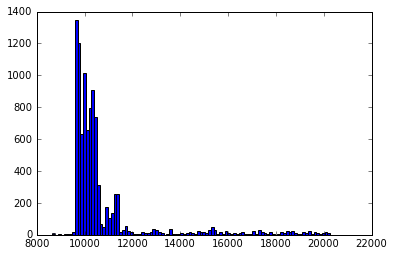

In [15]:
#multifig, multiax = plt.subplots(2, 1, figsize=(10, 10))
b0_val = np.mean(mcmc.trace('beta0')[:])
plt.hist(mcmc.trace('b1')[:], bins=100) # n,bins,patches = plt.hist(intputarray, bins=100)
plt.show()

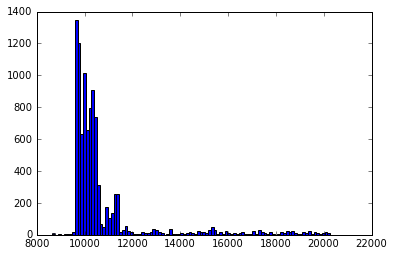

In [16]:
b1_val = np.mean(mcmc.trace('b1')[:])
plt.hist(mcmc.trace('b1')[:], bins=100)
plt.show()

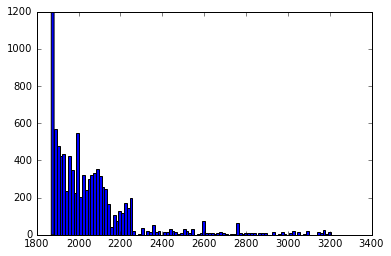

In [17]:
b4_val = np.mean(mcmc.trace('b4')[:])
plt.hist(mcmc.trace('b4')[:], bins=100)
plt.show()

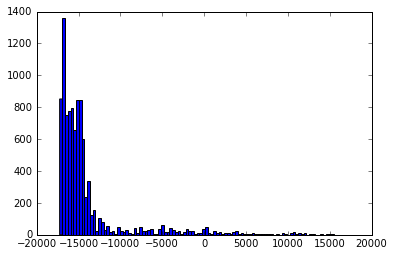

In [18]:
b3_val = np.mean(mcmc.trace('b3')[:])
plt.hist(mcmc.trace('b3')[:], bins=100)
plt.show()

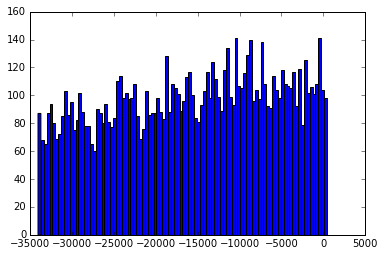

In [19]:
b2_val = np.mean(mcmc.trace('b2')[:])
plt.hist(mcmc.trace('b2')[:], bins=100)
plt.show()

# Print Parameter Estimates of your Equation

Reconstruct the parameter values (like you would see in a traditional regression results table)

In [20]:
print "B0: " + str(np.mean(b0_val)) 
print "B1: " + str(np.mean(b1_val)) 
print "B2: " + str(np.mean(b2_val)) 
print "B3: " + str(np.mean(b3_val)) 
print "B4: " + str(np.mean(b4_val)) 


B0: 127701.156741
B1: 10774.6274649
B2: -15785.7041837
B3: -13971.9797435
B4: 2065.56974014


Run the model through a MCMC procedure to get the estimations. For simplicity, use the input values of 10000, and 200 for the MCMC sample call. 

Obviously leverage the internet to get more background on MCMC (https://en.wikipedia.org/wiki/Markov_chain_Monte_Carlo). For more information on the MCMC method from PyMC, please read the following docs: https://pymc-devs.github.io/pymc/theory.html. The latter is really good reading and explains the apparatus fairly well.
